# CSC 594 HW\#4 XAI -- LIME (2): Explanations for Rock-Paper-Scissors Dataset
This code runs LIME (Local Interpretable Model-agnostic Explanations) on example images from the Rock-Paper-Scissors dataset. 

Some notes:

1.   The training dataset can be accessed using the same way as in HW#1, but this code uses an alternative way by accessing the shared folder on Google Drive (through a shortcut link).  Here are some references on how to mount shared folders and access files under them from your Python code -- [reference 1](https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab), [reference 2](https://buomsoo-kim.github.io/colab/2020/05/09/Colab-mounting-google-drive.md/), [reference 3](https://stackoverflow.com/questions/49351071/load-image-dataset-folder-or-zip-located-in-google-drive-to-google-colab).
2.   Only one model was built in this code, which is Keras Applications [MobileNetV2](https://keras.io/api/applications/mobilenet/#mobilenetv2-function). MobileNetV2 was chosen because its model is the smallest among the pretrained Keras CNN models.  
We load the pretrained model (with ImageNet weights) and **fine-tune** the model by unfreezing the top two blocks and training with the rock-paper-scissors training set.
3. Keras MobileNetV2 expects the input image pixel values in the range of [-1,1] (instead of [0,1]).  So some lines are added in the code to normalize/re-normalize the value range.
4. Some test images are selected from the test data.

### Setup -- Google Drive Mounting

In [ ]:
## Code piece to mount my Google Drive
from google.colab import drive 
drive.mount("/content/drive") # my Google root directory will be mapped here

Mounted at /content/drive


In [ ]:
# Change the working directory to the work directory (where the code and data files are).
import os
os.chdir('/content/drive/My Drive/CSC594ADL-2020fall/XAI')

# Ensure the files are there (in the folder)
!ls -l

total 1828
-rw------- 1 root root 492902 Oct 26 18:27 boathouselakerousseau1.jpg
-rw------- 1 root root 208133 Oct 26 18:25 boathouserow.jpg
-rw------- 1 root root  36706 Oct 26 20:09 xai_integrated_gradients.ipynb
-rw------- 1 root root 629787 Oct 28 21:49 xai_lime_image.ipynb
-rw------- 1 root root 503022 Oct 29 16:29 xai_lime_image_rps.ipynb


### Imports
Import some of the necessary utilities for manipulation of images, plotting, CNN models and numerical analysis.

In [ ]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

np.random.seed(222)
print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.3.0


## (1) Load the rps Dataset

In [ ]:
# The shared folder's link is https://drive.google.com/drive/folders/1Ge1glfAKhRHnxp4uQ4_dGwQ3m787ccrg?usp=sharing
# You access the folder and create a shortcut in your Drive.
# Training data is under the subfolder 'rps', and test data is under 'rps-test-set'.
# Change the 'directory' according to your drive setup.

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='../../ImageData/rps/',
    labels='inferred',
    label_mode='categorical',
    batch_size=16,
    image_size=(224, 224))

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='../../ImageData/rps-test-set/',
    labels='inferred',
    label_mode='categorical',
    batch_size=16,
    image_size=(224, 224))

train_ds = train_ds.map(lambda x, y: (tf.keras.applications.mobilenet_v2.preprocess_input(x), y))
valid_ds = valid_ds.map(lambda x, y: (tf.keras.applications.mobilenet_v2.preprocess_input(x), y))

Found 2520 files belonging to 3 classes.
Found 372 files belonging to 3 classes.


### (2) Load a Pre-trained Model and Fine-Tune it

This code uses MobileNetV2 available at [Keras Applications](https://keras.io/api/applications/) and fine-tunes it with the rps dataset.

In [ ]:
# create the base pretrained model
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

# a global spatial average pooling layer
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# a fully-connected layer.  Add a L2 regularizer to reduce overfitting.
x = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
# and a softmaxc layer -- we have 3 classes
predictions = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

# this is the model we will train
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
model.fit(train_ds, epochs=3, validation_data=valid_ds)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from MobileNetV2. We will freeze the bottom N layers
# and train the remaining top layers.

print ('-----------------')

# we chose to train the top 2 blocks in MobileNetV2, i.e. we will freeze
# the first 135 layers and unfreeze the rest:
for layer in model.layers[:135]:
   layer.trainable = False
for layer in model.layers[135:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate (but with momentum to speed up convergence)
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.00001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 blocks
# alongside the top Dense layers)
model.fit(train_ds, epochs=3, validation_data=valid_ds)


Epoch 1/3
158/158 [==============================] - 17s 108ms/step - loss: 0.4828 - accuracy: 0.9444 - val_loss: 0.5732 - val_accuracy: 0.8091
Epoch 2/3
158/158 [==============================] - 16s 103ms/step - loss: 0.1309 - accuracy: 0.9976 - val_loss: 0.4974 - val_accuracy: 0.7876
Epoch 3/3
158/158 [==============================] - 16s 104ms/step - loss: 0.1009 - accuracy: 0.9968 - val_loss: 0.4776 - val_accuracy: 0.8038
-----------------
Epoch 1/3
158/158 [==============================] - 18s 112ms/step - loss: 0.2155 - accuracy: 0.9790 - val_loss: 0.4723 - val_accuracy: 0.8091
Epoch 2/3
158/158 [==============================] - 17s 109ms/step - loss: 0.2089 - accuracy: 0.9817 - val_loss: 0.4740 - val_accuracy: 0.8065
Epoch 3/3
158/158 [==============================] - 17s 108ms/step - loss: 0.1872 - accuracy: 0.9881 - val_loss: 0.4714 - val_accuracy: 0.8091


### (3) Load test images
Select a few example images from the test set. 

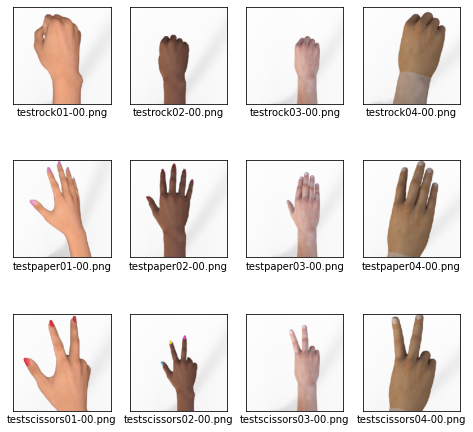

In [ ]:
# Load some test images
# The obtained images (orig_imgX) are still in the PIL Image format at this time.
from IPython.display import Image

img_target_size = (224,224)
datadir = '../../ImageData/rps-test-set/' # NEEDS change for your setup
target_categories = ['rock', 'paper', 'scissors']

prefix = 'test'
suffixes = ['01-00.png', '02-00.png', '03-00.png', '04-00.png'] # four distinct groups of images...

test_names = []
test_images = []

for category in target_categories:
  tnames = [prefix+category+suffix for suffix in suffixes]
  timages = [tf.keras.preprocessing.image.load_img(datadir+category+'/'+tname, target_size=img_target_size) for tname in tnames]

  test_names += tnames
  test_images += timages

#---------------
# Display the images
plt.figure(figsize=(8,8))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i])
    plt.xlabel(test_names[i])
plt.show()

### (3) Run the Model on One Test Image
Run the model and obtain predictions, which is a vector of 3 probabilities for the target classes (rock//paper//scissors).


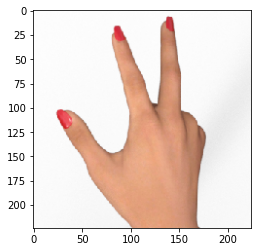

In [ ]:
import copy

# Pick one test image -- Change this to what you like to experiment
test_image = test_images[8]
x = copy.deepcopy(test_image)
x = tf.keras.preprocessing.image.img_to_array(x)
Xi = tf.keras.applications.mobilenet_v2.preprocess_input(x)

# Since MobileNet expects input pixel value in the range of [-1,1], we create
# a separate image only for the purpose of displaying.
img2 = Xi/2+0.5 # make the values between [0,1]

plt.imshow(img2)
plt.show()

In [ ]:
# Make predictions for this image.
# Ideally the model predicted the correct target category...

preds = model.predict(np.expand_dims(Xi, axis=0))
pred_classes = preds[0].argsort()[::-1] # prediction probabilities in descending order
result = [(target_categories[index], preds[0][index]) for index in pred_classes]
print (result)

[('scissors', 0.97368354), ('rock', 0.017920218), ('paper', 0.008396262)]


In [ ]:
# Set k in top_k to be 3 (since there are only 3 classes in this dataset)
topk = 3

## (4) LIME explanations

From here on, we focus on one CNN model and one example image at a time.  

**NOTE**: You can change the values and code here for your experimentation.

### Step 1: Create perturbations of image
For the case of image explanations, perturbations will be generated by turning on and off some of the superpixels in the image.

#### Extract super-pixels from image
Superpixels are generated using the quickshift segmentation algorithm. 

In [ ]:
import skimage.io 
import skimage.segmentation

superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
print ('Number of superpixdels: %s' % num_superpixels)

Number of superpixdels: 29


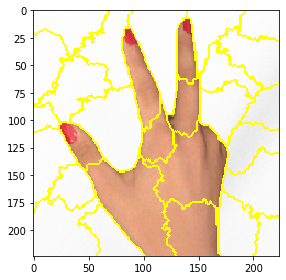

In [ ]:
# Display image with boundaries
skimage.io.imshow(skimage.segmentation.mark_boundaries(img2, superpixels))

#### Create random perturbations
In this code, we use 150 perturbations. However, for real life applications, a larger number of perturbations will produce more reliable explanations. 

A perturbation is essentially a mask (a vector of 0' and 1's) over superpixels, where `1` represents that a superpixel is on and `0` represents it is off. 

In [ ]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[3] #Show example of perturbation ([3] is an arbitrary choice)

array([1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 1])

The following function `perturb_image` perturbs the given image (`img`) based on a perturbation vector (`perturbation`) and predefined superpixels (`segments`).

In [ ]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

Let's use the previous function (and the appropriated image 'img2') to see what a perturbed image would look like:

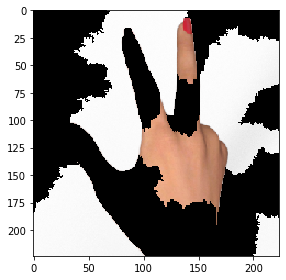

In [ ]:
skimage.io.imshow(perturb_image(img2,perturbations[3],superpixels)) # [3] is an arbitrary choice

### Step 2: Use ML classifier to predict classes of new generated images
This is the most computationally expensive step in LIME because a prediction for each perturbed image is computed. From the shape of the predictions we can see for each of the perturbations we have the output probability for each of the 3 classes. 

In [ ]:
predictions = []
for pert in perturbations: # for each perturbation mask,
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = model.predict(perturbed_img[np.newaxis,:,:,:]) # add batch_size dimension to predict
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(150, 1, 3)

### Step 3: Compute distances between the original image and each of the perturbed images and compute weights (importance) of each perturbed image
The distance between each randomly generated perturnation and the image being explained is computed using the cosine distance. For the shape of the `distances` array it can be noted that, as expected, there is a distance for every generated perturbation.

In [ ]:
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression

original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

#### Use kernel function to compute weights
The distances are then mapped to a value between zero and one (weight) using a kernel function. An example of a kernel function with different kernel widths is shown in the plot below. Here the x axis represents distances and the y axis the weights. Depeding on how we set the kernel width, it defines how wide we want the "locality" around our instance to be. This kernel width can be set based on expected distance values. For the case of cosine distances, we expect them to be somehow stable (between 0 and 1); therefore, no fine tunning of the kernel width might be required.

In [ ]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

### Step 4: Use `perturbations`, `predictions` and `weights` to fit an explainable (linear) model
A weighed linear regression model is fitted using data from the previous steps (perturbations, predictions and weights). Given that the class that we want to explain is 'scissors', when fitting the linear model we take from the predictions vector only the column corresponding to the top predicted class. Each coefficients in the linear model corresponds to one superpixel in the segmented image. These coefficients represent how important is each superpixel for the prediction of 'scissors'.

In [ ]:
class_to_explain = 2 # index of 'scissors'

# Then create a simpler model and fit it.  Weights are applied on instances (which are perturbations).
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 0.21992412,  0.0175149 , -0.04927467, -0.02843058,  0.01523497,
        0.02108651,  0.06627298, -0.01219338,  0.05111923,  0.14706244,
        0.05324972, -0.00669582,  0.2517554 ,  0.05571155,  0.06334667,
        0.06434246,  0.03587841,  0.09706663,  0.06294968, -0.01484956,
        0.00750325,  0.10329683,  0.03868571,  0.0148699 , -0.00112263,
        0.09972184,  0.04493126,  0.09325287, -0.02318051])

#### Compute top features (superpixels)
Now we just need to sort the coefficients to figure out which are the supperpixels that have larger coefficients (magnitude) for the prediction of labradors. The identifiers of these top features or superpixels are shown below. Even though here we use the magnitude of the coefficients to determine the most important features, other alternatives such as forward or backward elimination can be used for feature importance selection. 

In [ ]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([21,  9,  0, 12])

#### Show LIME explanation (image with top features)
Let's show the most important superpixels defined in the previous step in an image after covering up less relevant superpixels.

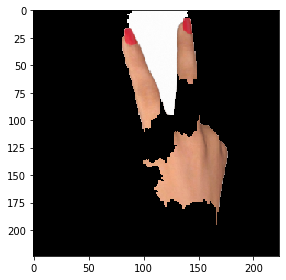

In [ ]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(img2,mask,superpixels) )